# Sign Language digit classifier

This notebook guides through the process of classifying sign language digits. It utilises a Convolutional Neural Network architecture built with Keras library. The purpose of this notebook is to showcase an examplary workflow when dealing with simple computer-vision based tasks.

## Introduction

In [52]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

RAND_SEED = 7
DATA_PATH = "data/data.npy"
LABELS_PATH = "data/labels.npy"

Let's load in our data and explore it a little bit.

In [53]:
X = np.load(DATA_PATH)
y = np.load(LABELS_PATH)

X.shape, y.shape

((2062, 64, 64), (2062, 10))

There are 2062 images in our dataset, each the size of 64x64 pixels. Every image has a corresponding label; there are 10 different classes in our data, making it a multiclass (multinominal) classification problem.

For now, our dataset looks like this:

In [54]:
X[0], y[0]

(array([[0.47450978, 0.46274507, 0.45098037, ..., 0.50196075, 0.5137255 ,
         0.52549016],
        [0.46666664, 0.45098037, 0.43921566, ..., 0.4980392 , 0.5098039 ,
         0.52156866],
        [0.45490193, 0.43921566, 0.42745095, ..., 0.49411762, 0.50196075,
         0.517647  ],
        ...,
        [0.4470588 , 0.4352941 , 0.4235294 , ..., 0.49019605, 0.4980392 ,
         0.5058824 ],
        [0.45490193, 0.44313723, 0.43137252, ..., 0.4980392 , 0.5058824 ,
         0.5137255 ],
        [0.46274507, 0.45098037, 0.43921566, ..., 0.50196075, 0.5098039 ,
         0.52156866]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

Looks like our images are already normalised (values between 0 and 1) but the labels are one-hot-encoded.

Let's check out the class distribution in our dataset.

In [55]:
unique, count = np.unique(np.argmax(y, axis=1), return_counts=True)
occurences = dict(zip(unique, count))
print(f"The number of occurences of each class in the dataset = {occurences}")

The number of occurences of each class in the dataset = {0: 205, 1: 206, 2: 206, 3: 206, 4: 207, 5: 207, 6: 207, 7: 206, 8: 208, 9: 204}


So far, so good; all the classes in our dataset are evenly distributed.

## Data visualisation

Let's prepare some visualisations to better understand our data, we'll start with a random sample of our dataset. Since we'll randomly reorder our data a couple of times, we can write a function for that aswell.

In [89]:
def randomise_data(image_data, label_data, random_seed):
    return np.random.RandomState(random_seed).permutation(image_data), np.random.RandomState(random_seed).permutation(label_data)

def display_rand_imgs(image_data, label_data, random_seed):
    images, labels = randomise_data(image_data, label_data, random_seed)
    
    fig, axes = plt.subplots(5, 5, figsize = (15,15))
    plt.suptitle("Random images and their labels", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(random_seed)
            image = images[index].reshape(64, 64)
            label = np.argmax(labels[index])
            axis.imshow(image, cmap='binary')
            axis.set_title(f"Number {label}")
            axis.set_axis_off()        

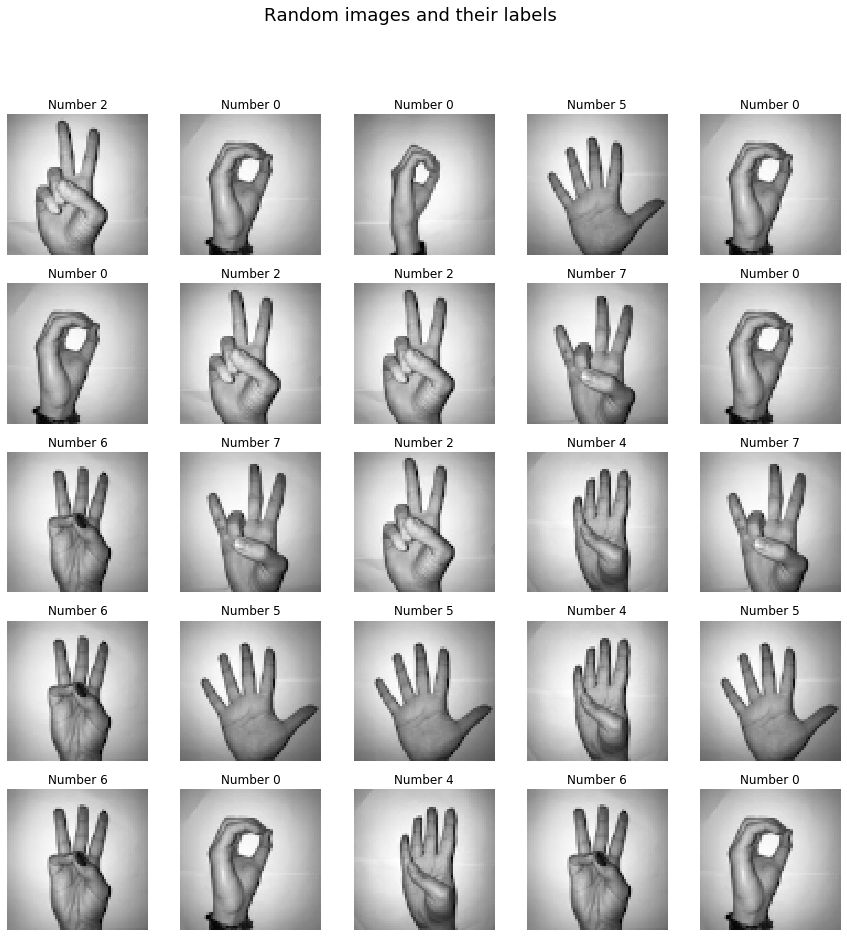

In [90]:
display_rand_imgs(X, y, RAND_SEED)

An interesting thing would be to plot the mean of every class and see whether they are (on average) different enough for our neural network to pick differences

In [92]:
count

array([205, 206, 206, 206, 207, 207, 207, 206, 208, 204], dtype=int64)

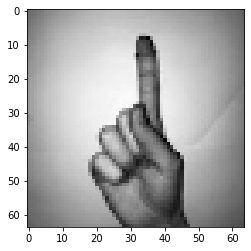

In [97]:
plt.imshow(X[205].reshape(64,64), cmap="binary")

In [130]:
current_count=0
for img_class in range(len(unique)):
    current_count += count[img_class]  
    print(current_count)

205
411
617
823
1030
1237
1444
1650
1858
2062


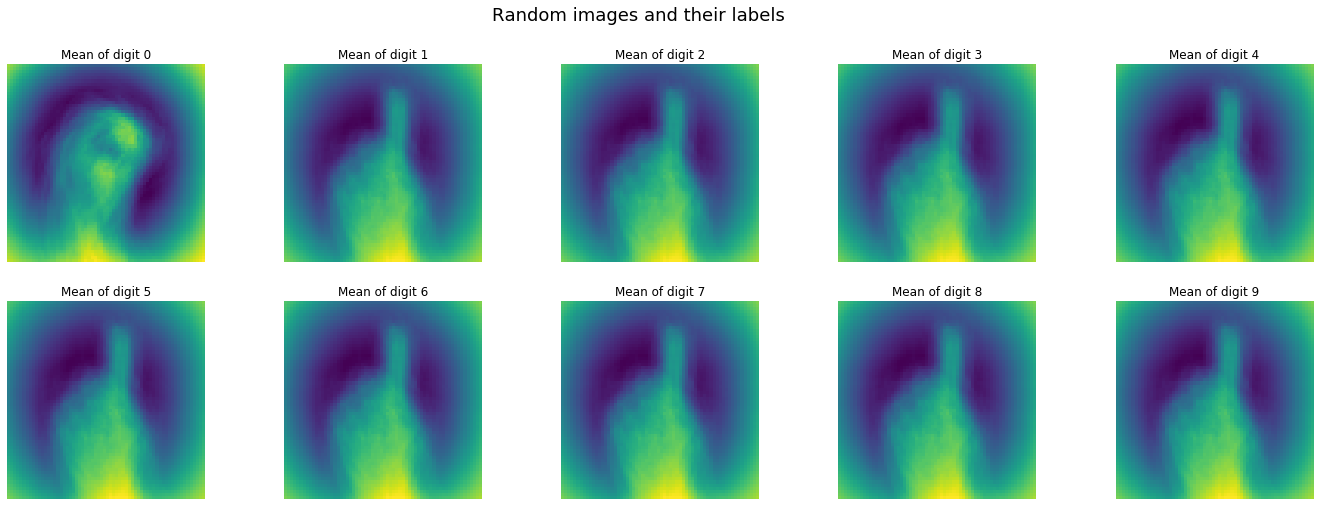

In [124]:
#reusing our old variables unique(every unique class) and count(number of occurences for each class)
plt.figure(figsize=(24,8))
plt.suptitle("Random images and their labels", fontsize=18)

for img_class in range(len(unique)):

    if img_class == 0:
        x_num = X[0: count[img_class]]
        mean_num = x_num.mean(axis=0)
    else:
        x_range_start = count[img_class-1]  
        x_range_end = count[img_class-1] + count[img_class]
        x_num = X[x_range_start:x_range_end] 
        mean_num = x_num.mean(axis=0) 
        
#     print(len(x_num))
#     print(x_num)
    plt.subplot(2,5,img_class+1)
    plt.title(f"Mean of digit {img_class}")
    plt.imshow(mean_num)
    plt.axis("off")
    

In [ ]:
#reusing our old variables unique(every unique class) and count(number of occurences for each class)
plt.figure(figsize=(24,8))
plt.suptitle("Random images and their labels", fontsize=18)

for img_class in range(len(unique)):
    x_num = X[0: count[img_class]]
    
        
    print(len(x_num))
    mean_num = x_num.mean(axis=0)

    plt.subplot(2,5,img_class+1)
    plt.title(f"Mean of digit {img_class}")
    plt.imshow(mean_num)
    plt.axis("off")
    

We can clearly see that there are some distinct features for every sign (every image class) which is good, since our neural network will be easily able to differentiate between them. Some misclassifications might happen between digits 6 through 8, because they are very similiar. 

## Data preprocessing

## Building our model

## Training a Convolutional Neural Network

## Evaluating the model

## Final visualisations and Conclusions